# TM10007 Assignment template -- ECG data

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [19]:
# Loads packages and loads used dataset
!git clone https://github.com/jveenland/tm10007_ml.git

import zipfile
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import sys
from google.colab import output
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel
from sklearn import datasets as ds
from sklearn import neighbors
from sklearn import metrics


with zipfile.ZipFile('/content/tm10007_ml/ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_ml/ecg')

data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

fatal: destination path 'tm10007_ml' already exists and is not an empty directory.
The number of samples: 827
The number of columns: 9001


In [20]:
# Check if the data contains any missing values. No missing values were found
data.isnull().values.any()

False

In [21]:
# Splitting data into training and test dataset
train_frequency, test_frequency, train_label, test_label = train_test_split(
        data, data['label'], test_size=0.2, train_size=0.8, random_state=42,
        stratify=data['label'])
train_frequency.pop("label")
test_frequency.pop("label")


115    0
152    0
324    0
80     0
640    0
      ..
688    0
2      0
386    0
606    0
608    0
Name: label, Length: 166, dtype: int64

In [22]:
# Scales outliers down 
# Makes every point that is above mean + 2*SD equal to mean + 2*SD
# Should take no longer than 2 minutes
mean_frequency = train_frequency.mean()
std_frequency = train_frequency.std()

print("Checking all features...")
for col in train_frequency.columns: 
  train_frequency[col][train_frequency[col] > mean_frequency[col]+2*std_frequency[col]] = mean_frequency[col]+2*std_frequency[col]
  train_frequency[col][train_frequency[col] < mean_frequency[col]-2*std_frequency[col]] = mean_frequency[col]-2*std_frequency[col]
for col in test_frequency.columns:
  test_frequency[col][test_frequency[col] > mean_frequency[col]+2*std_frequency[col]] = mean_frequency[col]+2*std_frequency[col]
  test_frequency[col][test_frequency[col] < mean_frequency[col]-2*std_frequency[col]] = mean_frequency[col]-2*std_frequency[col]
print("Replacement done!")

Checking all features...
Replacement done!


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


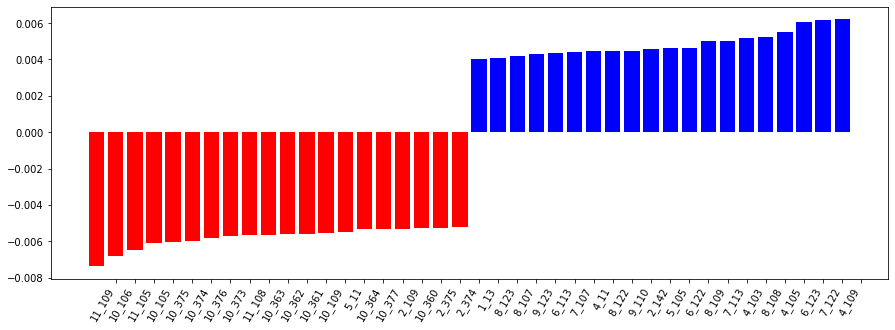

In [23]:
# Feature importance on whole dataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

def plot_coefficients(classifier, feature_names, top_features=20):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 5))
 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
 plt.show()

cv = CountVectorizer()
cv.fit(train_frequency)
X_train = cv.transform(train_frequency)

svm = LinearSVC()
svm.fit(train_frequency, train_label)
plot_coefficients(svm, cv.get_feature_names())

Amount of principal components: 349


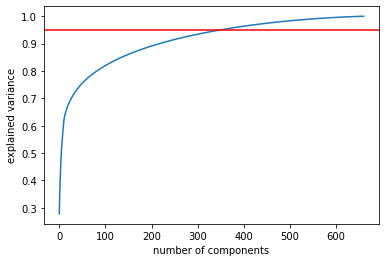

In [24]:
# Scaling procedure
scaler = StandardScaler()
scaler.fit(train_frequency)
train_frequency_scaled = scaler.transform(train_frequency)
test_frequency_scaled = scaler.transform(test_frequency)

# PCA
pca = PCA(n_components=661, random_state = 42)
pca.fit(train_frequency_scaled)
pca_val = np.cumsum(pca.explained_variance_ratio_ * 100)
nr_PCA = np.where(pca_val>=95)
nr_PCA = nr_PCA[0][0]

pca_95 = PCA(n_components=nr_PCA, random_state = 42)
pca_95.fit(train_frequency_scaled)
train_frequency_trans = pca_95.transform(train_frequency_scaled)
test_frequency_trans = pca_95.transform(test_frequency_scaled)

#Plot explained variance of PCA
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y = 0.95, color = 'r', linestyle = '-')
plt.xlabel('number of components')
plt.ylabel('explained variance')

print(f"Amount of principal components: {nr_PCA}")

RandomForestClassifier(n_estimators=1, random_state=42)
Misclassified: 59 / 219
RandomForestClassifier(n_estimators=2, random_state=42)
Misclassified: 40 / 219
RandomForestClassifier(n_estimators=5, random_state=42)
Misclassified: 50 / 219
RandomForestClassifier(n_estimators=10, random_state=42)
Misclassified: 39 / 219
RandomForestClassifier(n_estimators=50, random_state=42)
Misclassified: 40 / 219


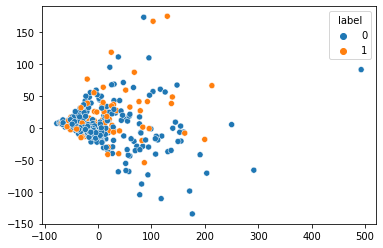

In [25]:
# Test complexity of the data after PCA
# Construct classifiers
clsfs = [RandomForestClassifier(n_estimators=1, random_state=42),
         RandomForestClassifier(n_estimators=2, random_state=42),
         RandomForestClassifier(n_estimators=5, random_state=42),
         RandomForestClassifier(n_estimators=10, random_state=42),
         RandomForestClassifier(n_estimators=50, random_state=42)]

# Now use the classifiers on all datasets
for clf in clsfs:
  X_train, X_test, y_train, y_test = train_test_split(train_frequency_trans, train_label, test_size=0.33, random_state=42)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf)
  print("Misclassified: %d / %d" % ((y_test != y_pred).sum(), y_test.shape[0]))

# Plot first two principle components to help visualize the data  
seaborn.scatterplot(x=train_frequency_trans[:, 0], y=train_frequency_trans[:, 1], hue=train_label)

Feature ranking:
1. feature 13 (0.025478)
2. feature 49 (0.020463)
3. feature 1 (0.014084)
4. feature 2 (0.010547)
5. feature 6 (0.009882)
6. feature 7 (0.009513)
7. feature 52 (0.008799)
8. feature 8 (0.008691)
9. feature 60 (0.008419)
10. feature 9 (0.008077)
11. feature 71 (0.007746)
12. feature 42 (0.006982)
13. feature 45 (0.006781)
14. feature 99 (0.006752)
15. feature 5 (0.006285)
16. feature 55 (0.006199)
17. feature 51 (0.005869)
18. feature 0 (0.005598)
19. feature 192 (0.005509)
20. feature 86 (0.005400)
21. feature 343 (0.005329)
22. feature 3 (0.005223)
23. feature 16 (0.005174)
24. feature 241 (0.005118)
25. feature 267 (0.005112)
26. feature 156 (0.005109)
27. feature 56 (0.005092)
28. feature 57 (0.005066)
29. feature 318 (0.004972)
30. feature 14 (0.004960)
31. feature 11 (0.004926)
32. feature 259 (0.004913)
33. feature 75 (0.004834)
34. feature 63 (0.004772)
35. feature 185 (0.004676)
36. feature 62 (0.004502)
37. feature 116 (0.004483)
38. feature 320 (0.004362)
39.

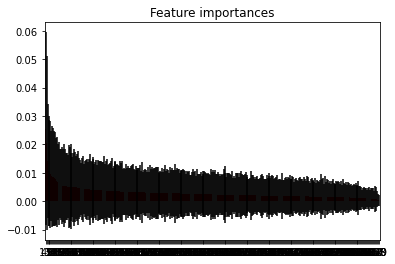

In [26]:
# Build a forest and compute the feature importances
forest = RandomForestClassifier(n_estimators=100)
forest.fit(train_frequency_trans, train_label)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train_frequency_trans.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(train_frequency_trans.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(train_frequency_trans.shape[1]), indices)
plt.xlim([-1, train_frequency_trans.shape[1]])
plt.show()

In [27]:
# K nearest neighbor with crossvalidation
clsfs = []
knn2 = neighbors.KNeighborsClassifier()
# Create a dictionary of all values we want to test for n_neighbors
param_grid = {"n_neighbors": list(range(1, 26, 1))}
# Use gridsearch to test all values for n_neighbors
cv = StratifiedKFold(5,shuffle = True, random_state = 42)
knn_gscv = model_selection.GridSearchCV(knn2, param_grid, cv=cv)
# Fit model to data
knn_gscv.fit(train_frequency_trans, train_label)
# Get resulting classifier
clf_knn = knn_gscv.best_estimator_
print(clf_knn)
cv_scores = cross_val_score(clf_knn, train_frequency_trans, train_label, cv=cv, scoring='accuracy')
print(cv_scores)
print(f'cv_score knn mean: {np.mean(cv_scores)}')

# Append kNN classifier to list of classifiers
clsfs.append(clf_knn)


KNeighborsClassifier(n_neighbors=3)
[0.85714286 0.84848485 0.84090909 0.84090909 0.82575758]
cv_score knn mean: 0.8426406926406926


In [28]:
# Initial classification with SVM 
# Construct SVM classifiers (linear, rbf and poly), fit model to data,
# cross-validate and append to list of classifiers
svmlin = SVC(kernel='linear', gamma='scale', random_state=42)
svmlin.fit(train_frequency_trans, train_label)
scoresl = cross_val_score(svmlin, train_frequency_trans, train_label, cv=cv)
print(f'cv_score SVM(kernel=linear) mean: {np.mean(scoresl)}')
clsfs.append(svmlin)

svmrbf = SVC(kernel='rbf', gamma='scale', random_state=42)
svmrbf.fit(train_frequency_trans, train_label)
scoresr = cross_val_score(svmrbf, train_frequency_trans, train_label, cv=cv)
print(f'cv_score SVM(kernel=rbf) mean: {np.mean(scoresr)}')
clsfs.append(svmrbf)

svmpoly = SVC(kernel='poly', gamma='scale', random_state=42)
svmpoly.fit(train_frequency_trans, train_label)
scoresp = cross_val_score(svmpoly, train_frequency_trans, train_label, cv=cv)
print(f'cv_score SVM(kernel=poly) mean: {np.mean(scoresp)}')
clsfs.append(svmpoly)

cv_score SVM(kernel=linear) mean: 0.8275575301891092
cv_score SVM(kernel=rbf) mean: 0.8335839598997493
cv_score SVM(kernel=poly) mean: 0.8184438368648894


In [29]:
# SVM with hyperparameter tuning (Gridsearch)

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear','poly'],
              'random_state': [42]}
print("Starting gridsearch...") 
grid = model_selection.GridSearchCV(SVC(), param_grid, refit = True)
 
# fitting the model for grid search
grid.fit(train_frequency_trans, train_label)
print("Gridsearch complete!")

# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
clf_svm = grid.best_estimator_
print(clf_svm)

# Append hypertuned SVM classifier to list of classifiers
clsfs.append(clf_svm)

cv_scores_svm = cross_val_score(clf_svm, train_frequency_trans, train_label, cv=cv)
print(cv_scores_svm)
print(f'cv_score svm mean: {np.mean(cv_scores_svm)}')

Starting gridsearch...
Gridsearch complete!
{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf', 'random_state': 42}
SVC(C=100, gamma=0.0001, random_state=42)
[0.81954887 0.84090909 0.84090909 0.87878788 0.84848485]
cv_score svm mean: 0.845727956254272


In [30]:
# Initial RandomForest Classifier
clsfs_RF = [RandomForestClassifier(n_estimators=1, bootstrap=True, random_state=42),
         RandomForestClassifier(n_estimators=1, bootstrap=False, random_state=42),
         RandomForestClassifier(n_estimators=2, bootstrap=True, random_state=42),
         RandomForestClassifier(n_estimators=2, bootstrap=False, random_state=42),
         RandomForestClassifier(n_estimators=5, bootstrap=True, random_state=42),
         RandomForestClassifier(n_estimators=5, bootstrap=False, random_state=42),
         RandomForestClassifier(n_estimators=10, bootstrap=True, random_state=42),
         RandomForestClassifier(n_estimators=10, bootstrap=False, random_state=42),
         RandomForestClassifier(n_estimators=50, bootstrap=True, random_state=42),
         RandomForestClassifier(n_estimators=50, bootstrap=False, random_state=42)]
clsfs.extend(clsfs_RF)

# Now use the classifiers on all datasets
for clf in clsfs_RF:
  clf.fit(train_frequency_trans, train_label)
  y_pred = clf.predict(train_frequency_trans)
  print(clf)
  print("Misclassified: %d / %d" % ((train_label != y_pred).sum(), train_frequency_trans.shape[0]))

  # Cross validation
  cv_score_RF = cross_val_score(clf, train_frequency_trans, train_label, cv=cv)
  print(f'cv_score RF mean: {np.mean(cv_score_RF)}')


RandomForestClassifier(n_estimators=1, random_state=42)
Misclassified: 56 / 661
cv_score RF mean: 0.7050353155616313
RandomForestClassifier(bootstrap=False, n_estimators=1, random_state=42)
Misclassified: 0 / 661
cv_score RF mean: 0.729209387104124
RandomForestClassifier(n_estimators=2, random_state=42)
Misclassified: 52 / 661
cv_score RF mean: 0.794269765322397
RandomForestClassifier(bootstrap=False, n_estimators=2, random_state=42)
Misclassified: 0 / 661
cv_score RF mean: 0.7987696514012302
RandomForestClassifier(n_estimators=5, random_state=42)
Misclassified: 14 / 661
cv_score RF mean: 0.7881977671451356
RandomForestClassifier(bootstrap=False, n_estimators=5, random_state=42)
Misclassified: 0 / 661
cv_score RF mean: 0.7866712235133286
RandomForestClassifier(n_estimators=10, random_state=42)
Misclassified: 13 / 661
cv_score RF mean: 0.8199817726133516
RandomForestClassifier(bootstrap=False, n_estimators=10, random_state=42)
Misclassified: 0 / 661
cv_score RF mean: 0.8230006835269995


In [31]:
# Random Forest with hyperparameter tuning (Gridsearch)

# defining parameter range
param_grid_RF = {'bootstrap': [True],
              'n_estimators': [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)],
              'random_state': [42]}

print("Starting gridsearch...") 
grid_RF = model_selection.GridSearchCV(RandomForestClassifier(), param_grid_RF, refit = True)
 
# fitting the model for grid search
grid_RF.fit(train_frequency_trans, train_label)
print("Gridsearch complete!")

# print best parameter after tuning
print(grid_RF.best_params_)
 
# print how our model looks after hyper-parameter tuning
clf_rf = grid_RF.best_estimator_
print(clf_rf)

# Append hypertuned RF classifier to list of classifiers
clsfs.append(clf_rf)

cv_scores_rf = cross_val_score(clf_rf, train_frequency_trans, train_label, cv=cv)
print(cv_scores_rf)
print(f'cv_score RF mean: {np.mean(cv_scores_rf)}')

Starting gridsearch...
Gridsearch complete!
{'bootstrap': True, 'n_estimators': 18, 'random_state': 42}
RandomForestClassifier(n_estimators=18, random_state=42)
[0.81954887 0.83333333 0.81818182 0.82575758 0.81060606]
cv_score RF mean: 0.8214855320118477


In [32]:
# Statistics for the analysis of classifier performance
from sklearn import metrics

for clf in clsfs:
    y_pred = clf.predict(train_frequency_trans)

    if hasattr(clf, 'predict_proba'):
    # The first column gives the probability for class = 0, so we take
    # the second which gives the probability class = 1:
        y_score = clf.predict_proba(train_frequency_trans)[:, 1]
    else:
       y_score = y_pred

    auc = metrics.roc_auc_score(train_label, y_score)
    accuracy = metrics.accuracy_score(train_label, y_pred)
    F1 = metrics.f1_score(train_label,y_pred)
    precision = metrics.precision_score(train_label,y_pred)
    recall = metrics.recall_score(train_label, y_pred)

    # accuracy, AUC, f1score, precision, recall
    print(str(clf))
    print('Acc: ' + str(accuracy))
    print('AUC: ' + str(auc))
    print('F1: ' + str(F1))
    print('precision: ' + str(precision))
    print('recall: ' + str(recall))
    print()

KNeighborsClassifier(n_neighbors=3)
Acc: 0.886535552193646
AUC: 0.9547668426344897
F1: 0.5398773006134969
precision: 0.9565217391304348
recall: 0.37606837606837606

SVC(kernel='linear', random_state=42)
Acc: 1.0
AUC: 1.0
F1: 1.0
precision: 1.0
recall: 1.0

SVC(random_state=42)
Acc: 0.8925869894099848
AUC: 0.6965811965811965
F1: 0.5644171779141104
precision: 1.0
recall: 0.39316239316239315

SVC(kernel='poly', random_state=42)
Acc: 0.8744326777609682
AUC: 0.6452991452991453
F1: 0.4503311258278146
precision: 1.0
recall: 0.2905982905982906

SVC(C=100, gamma=0.0001, random_state=42)
Acc: 1.0
AUC: 1.0
F1: 1.0
precision: 1.0
recall: 1.0

RandomForestClassifier(n_estimators=1, random_state=42)
Acc: 0.9152798789712556
AUC: 0.8378346530920062
F1: 0.75
precision: 0.7850467289719626
recall: 0.717948717948718

RandomForestClassifier(bootstrap=False, n_estimators=1, random_state=42)
Acc: 1.0
AUC: 1.0
F1: 1.0
precision: 1.0
recall: 1.0

RandomForestClassifier(n_estimators=2, random_state=42)
Acc: 0.9

# **`Classifier evaluation on test data`**

In [33]:
# Use chosen classifier on the test data
# Classifier = 'KNN classifier with 7 neighbors'

chosen_clf = neighbors.KNeighborsClassifier(n_neighbors=3)
chosen_clf.fit(train_frequency_trans, train_label)
y_pred = chosen_clf.predict(test_frequency_trans)

if hasattr(chosen_clf, 'predict_proba'):
  y_score = chosen_clf.predict_proba(test_frequency_trans)[:, 1]
else:
  y_score = y_pred

auc = metrics.roc_auc_score(test_label, y_score)
accuracy = metrics.accuracy_score(test_label, y_pred)
F1 = metrics.f1_score(test_label,y_pred)
precision = metrics.precision_score(test_label,y_pred)
recall = metrics.recall_score(test_label, y_pred)

# Misclassified, accuracy, AUC, f1-score, precision, recall
print(str(chosen_clf))
print("Misclassified: %d / %d" % ((test_label != y_pred).sum(), test_frequency_trans.shape[0]))
print('Acc: ' + str(accuracy))
print('recall: ' + str(recall))

KNeighborsClassifier(n_neighbors=3)
Misclassified: 27 / 166
Acc: 0.8373493975903614
recall: 0.10344827586206896


In [34]:
# Use chosen classifier on the test data
# Classifier = 'SVM classifier with paramters C=100, gamma=0.0001 and rbf kernel'

chosen_clf = SVC(C=100, gamma=0.0001, kernel="rbf", random_state=42)
chosen_clf.fit(train_frequency_trans, train_label)
y_pred = chosen_clf.predict(test_frequency_trans)

if hasattr(chosen_clf, 'predict_proba'):
  y_score = chosen_clf.predict_proba(test_frequency_trans)[:, 1]
else:
  y_score = y_pred

auc = metrics.roc_auc_score(test_label, y_score)
accuracy = metrics.accuracy_score(test_label, y_pred)
F1 = metrics.f1_score(test_label,y_pred)
precision = metrics.precision_score(test_label,y_pred)
recall = metrics.recall_score(test_label, y_pred)

# Misclassified, accuracy, AUC, f1-score, precision, recall
print(str(chosen_clf))
print("Misclassified: %d / %d" % ((test_label != y_pred).sum(), test_frequency_trans.shape[0]))
print('Acc: ' + str(accuracy))
print('recall: ' + str(recall))

SVC(C=100, gamma=0.0001, random_state=42)
Misclassified: 27 / 166
Acc: 0.8373493975903614
recall: 0.20689655172413793


In [35]:
# Use chosen classifier on the test data
# Classifier = 'RandomForestClassifier with 20 estimators'

chosen_clf = RandomForestClassifier(n_estimators=18, random_state=42)
chosen_clf.fit(train_frequency_trans, train_label)
y_pred = chosen_clf.predict(test_frequency_trans)

if hasattr(chosen_clf, 'predict_proba'):
  y_score = chosen_clf.predict_proba(test_frequency_trans)[:, 1]
else:
  y_score = y_pred

auc = metrics.roc_auc_score(test_label, y_score)
accuracy = metrics.accuracy_score(test_label, y_pred)
F1 = metrics.f1_score(test_label,y_pred)
precision = metrics.precision_score(test_label,y_pred)
recall = metrics.recall_score(test_label, y_pred)

# Misclassified, accuracy, AUC, f1-score, precision, recall
print(str(chosen_clf))
print("Misclassified: %d / %d" % ((test_label != y_pred).sum(), test_frequency_trans.shape[0]))
print('Acc: ' + str(accuracy))
print('recall: ' + str(recall))

RandomForestClassifier(n_estimators=18, random_state=42)
Misclassified: 28 / 166
Acc: 0.8313253012048193
recall: 0.034482758620689655
